In [1]:
%cd /data/gunsbrother/repos/vq2d-lightning
%load_ext autoreload
%autoreload 2

/data/gunsbrother/repos/vq2d-lightning


/home/gunsbrother/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from IPython.display import Image as IPImage
import json

from ltvu.lit.model import LitModule
from ltvu.lit.data import LitVQ2DDataModule

import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from diffusers.utils import make_image_grid

from scipy.signal import find_peaks, medfilt

import torch
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
from PIL import Image, ImageDraw
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from pathlib import Path


def ten2pil(tensor, pad: float = 0.02, alpha = None, cmap = 'viridis'):
    assert tensor.dim() in (2, 3)  # (H, W), (C, H, W)
    tensor = tensor.cpu()
    tensor -= tensor.min()
    tensor /= tensor.max()

    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
        assert tensor.shape[-1] == 3

    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [pad, pad, 1. - 2* pad, 1. - 2 * pad])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(tensor, aspect='equal', alpha=alpha, cmap=cmap)

    plots_io = BytesIO()
    fig.savefig(plots_io, format='jpg' if alpha is None else 'png', bbox_inches='tight', pad_inches=0)
    plt.close()

    img = Image.open(plots_io)
    # plots_io.close()
    return img

GlobalHydra.instance().clear()
OmegaConf.clear_resolvers()
OmegaConf.register_new_resolver("job_type", lambda : 'debug')
OmegaConf.register_new_resolver('runtime_outdir', lambda : 'outputs/tmp')
OmegaConf.register_new_resolver("eval", eval)
OmegaConf.register_new_resolver("tuple", lambda *args: tuple(args))
hydra.initialize(config_path='config', job_name='asdasdasdasdasd')

/tmp/ipykernel_1539830/2795414477.py:55: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='config', job_name='asdasdasdasdasd')


hydra.initialize()

In [3]:
anns = json.load(open('data/vq_v2_val_anno.json'))
quid2ann = {f"{ann['annotation_uid']}_{ann['query_set']}": ann for ann in anns}

path_ckpt = 'outputs/batch/2024-09-15/123741/epoch=61-prob_acc=0.7739.ckpt'
plm_base = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm_base.eval()
plm_base.freeze()

path_ckpt = 'outputs/ckpts/34597/epoch=47-prob_acc=0.7977.ckpt'
plm = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm.eval()
plm.freeze()

preds = torch.load('outputs/ckpts/34597/intermediate_predictions.pt', weights_only=True)

eval_config = hydra.compose(config_name='eval', overrides=[
    f'ckpt={path_ckpt.replace('=', '\\=')}',
    f'batch_size=1',
    f'num_workers=4',
    f'prefetch_factor=1'
])
pdm = LitVQ2DDataModule(eval_config)  # won't use trainer here nor batched forward pass so no need to load the eval config and plm.config is enough
pdm.batch_size = 1

In [4]:
inter_preds1 = torch.load('outputs/batch/2024-09-15/123741/vq2d/val/clean/intermediate_predictions.pt', weights_only=True)
final_preds = json.load(open('outputs/batch/2024-09-15/123741/vq2d/val/clean/predictions.json'))
quid2pred1 = {}
for video_preds in final_preds['results']['videos']:
    for clip_preds in video_preds['clips']:
        for qset_preds in clip_preds['predictions']:
            annotation_uid = qset_preds['annotation_uid']
            for qset_id, preds in qset_preds['query_sets'].items():
                qset_uuid = f"{annotation_uid}_{qset_id}"
                quid2pred1[qset_uuid] = preds
print(len(quid2pred1))

inter_preds2 = torch.load('outputs/ckpts/34597/intermediate_predictions.pt', weights_only=True)
final_preds = json.load(open('outputs/ckpts/34597/predictions.json'))
quid2pred2 = {}
for video_preds in final_preds['results']['videos']:
    for clip_preds in video_preds['clips']:
        for qset_preds in clip_preds['predictions']:
            annotation_uid = qset_preds['annotation_uid']
            for qset_id, preds in qset_preds['query_sets'].items():
                qset_uuid = f"{annotation_uid}_{qset_id}"
                quid2pred2[qset_uuid] = preds
print(len(quid2pred2))

4504
4504


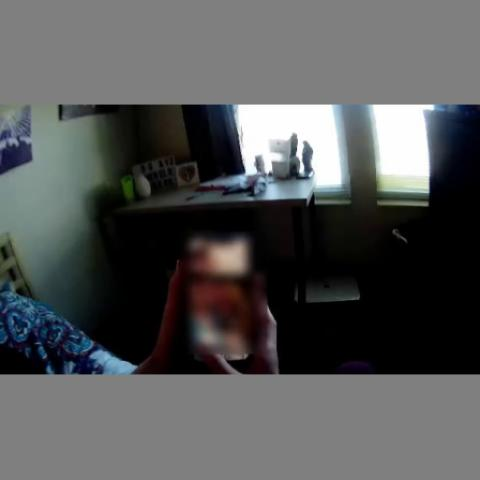

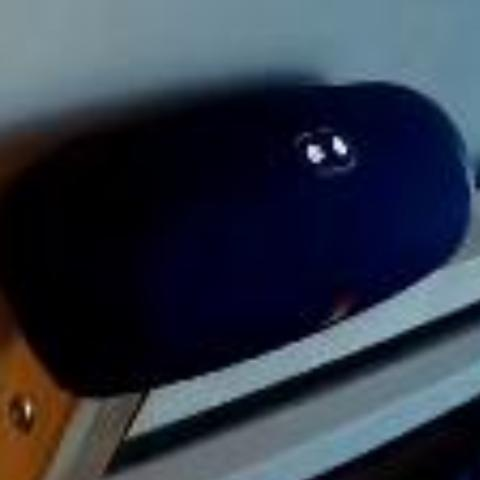

In [58]:
# get
# bidx = 2
# bidx = 300  # mean iou: 0 vs. 0.450
# bidx = 1307  # mean iou:
# bidx = 2300  # 슬리퍼
# bidx = 2305  # 물병
# bidx = 2333  # 상자
# bidx = 2334  # 화분
# bidx = 4001  # 주걱: 화면 전환 빠름
# bidx = 4013  # 화분: 화면 전환 빠름
# bidx = 3900  # 예초기: baseline iou 0.197
# bidx = 3906  # 메탈프레임: baseline prob 0.56
# bidx = 3915
# bidx = 236  # 잘 나오는 화분
# bidx = 824  # 전화기

# bidx = 301
# bidx = 329
# bidx = 370
# bidx = 2102
bidx = 2273


batch = pdm.get_val_sample(idx=bidx)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.cuda()

display(ten2pil(batch['segment'][0][len(batch['segment'][0]) // 2]))
display(ten2pil(batch['query'][0]))

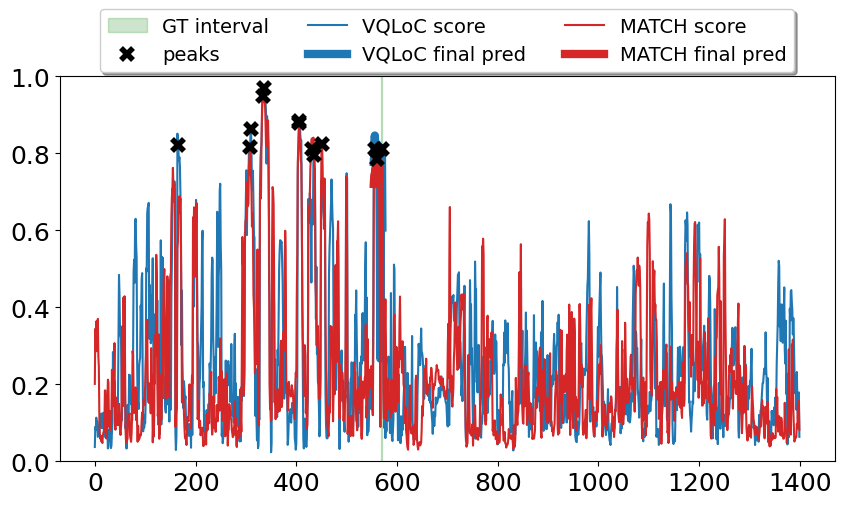

In [38]:
qset_uuid = f"{batch['annotation_uid'][0]}_{batch['query_set'][0]}"
gt_range = quid2ann[qset_uuid]['response_track_valid_range']

def compute_final_preds(preds, qset_uuid):
    ret_scores = preds[qset_uuid]['ret_scores']
    probs = ret_scores.sigmoid().cpu().numpy()
    probs_sm = medfilt(probs, kernel_size=5)
    peaks, _ = find_peaks(probs_sm)
    max_peak_prob = probs_sm[peaks].max()
    valid_peak_thres = max_peak_prob * 0.8
    peaks = peaks[probs_sm[peaks] > valid_peak_thres]
    last_valid_peak = peaks[-1]
    plat_thres = 0.7 * probs_sm[last_valid_peak]
    plat_idxs = np.where(probs_sm > plat_thres)[0]
    disc_idxs = np.where(np.diff(plat_idxs) > 1)[0]
    for i_from, i_to in zip(disc_idxs[:-1], disc_idxs[1:]):
        plat_idxs_tmp = plat_idxs[i_from+1:i_to]
        if last_valid_peak in plat_idxs_tmp:
            plat_idxs = plat_idxs_tmp
            break
    else:
        plat_idxs = plat_idxs[disc_idxs[-1]+1:]
    assert last_valid_peak in plat_idxs
    return probs, probs_sm, peaks, plat_idxs, plat_thres

# plot
probs, probs_sm, peaks, plat_idxs, plat_thres = compute_final_preds(inter_preds2, qset_uuid)
probs1, probs_sm1, peaks1, plat_idxs1, plat_thres1 = compute_final_preds(inter_preds1, qset_uuid)

fig, ax = plt.subplots(figsize=(10, 5))
plt.axvspan(gt_range[0], gt_range[1], color='g', alpha=0.2, label='GT interval')
plt.plot(peaks, probs[peaks], "x", color='k', markersize=8, markeredgewidth=4, zorder=10)
plt.plot(peaks1, probs1[peaks1], "x", color='k', label='peaks', markersize=8, markeredgewidth=4, zorder=10)

pp = plt.plot(probs1, label='VQLoC score')
color = pp[0].get_color()
plt.plot(plat_idxs1, probs1[plat_idxs1], color=color, lw=6, label='VQLoC final pred')

pp = plt.plot(probs, c=plt.get_cmap('tab20')(6), label='MATCH score')
color = pp[0].get_color()
plt.plot(plat_idxs, probs[plat_idxs], color=color, lw=6, label='MATCH final pred')

plt.setp(plt.gca().get_xticklabels(), fontsize=18)
plt.setp(plt.gca().get_yticklabels(), fontsize=18)
plt.gca().legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.2),
    ncol=3, fancybox=True, shadow=True, fontsize=14)
plt.ylim(0, 1)
plt.show()

In [39]:
batch['seg_idxs'][0].cpu().numpy()

array([556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
       569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581,
       582, 583, 584, 585, 586, 587])

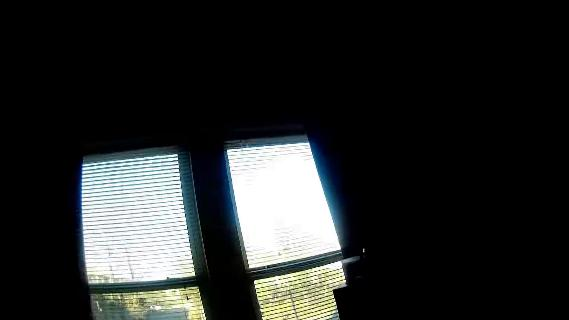

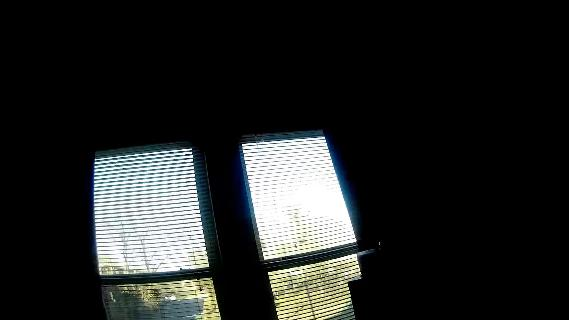

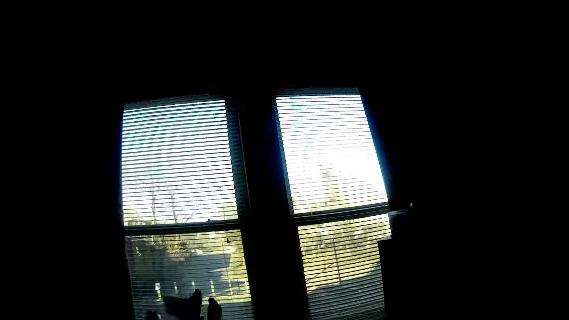

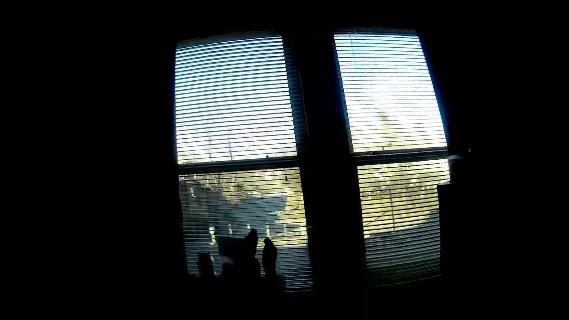

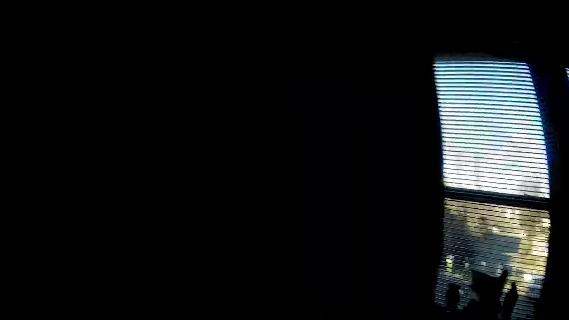

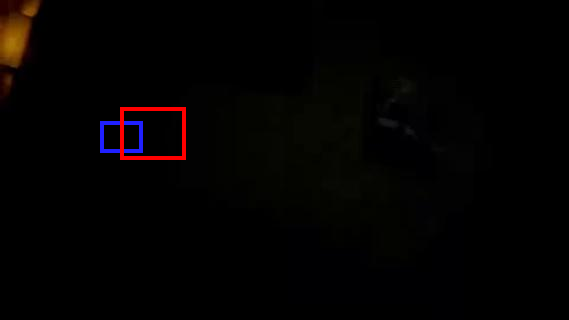

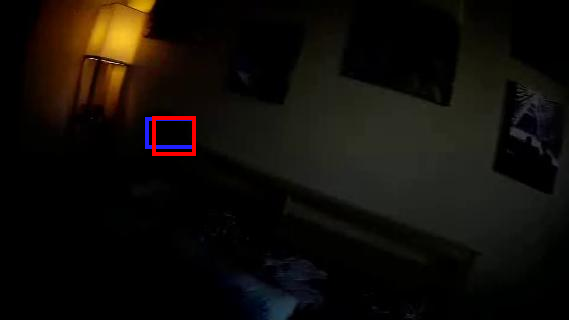

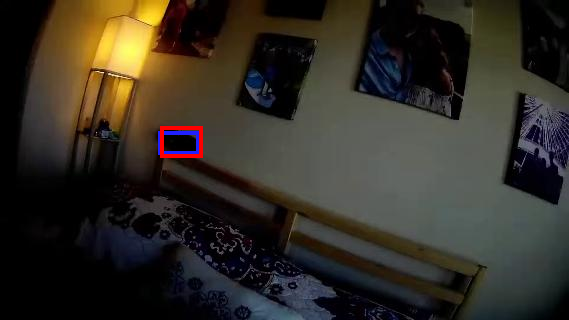

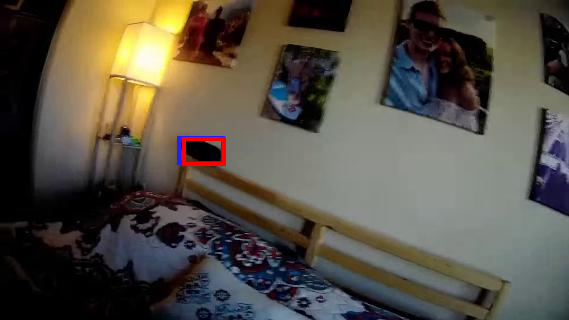

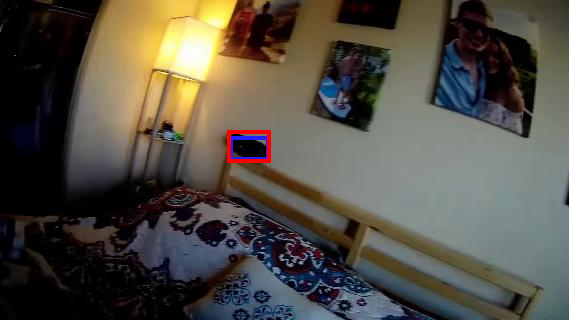

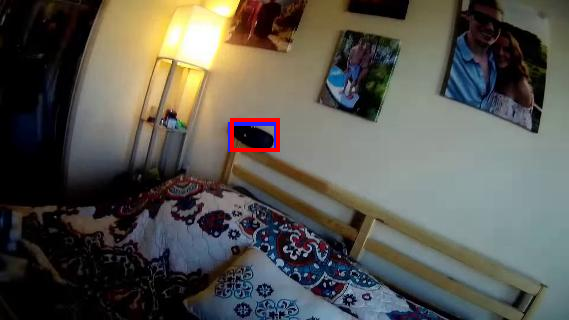

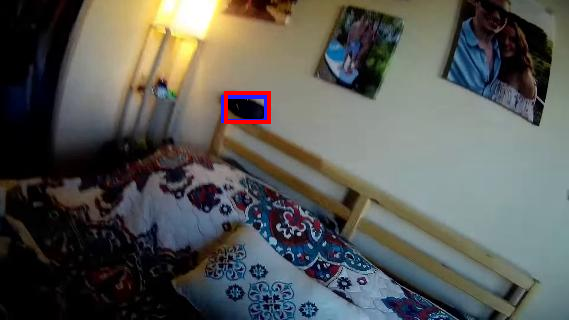

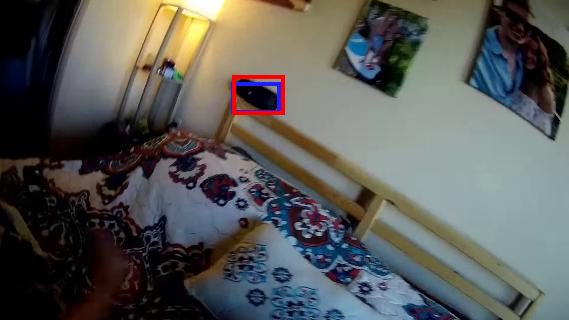

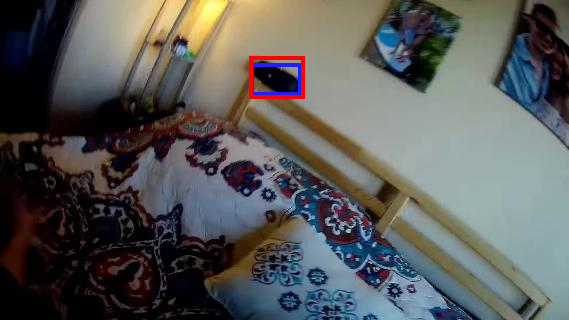

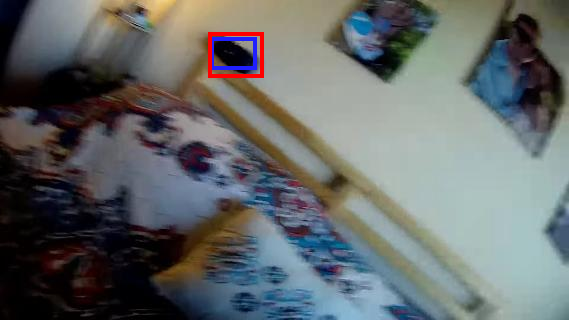

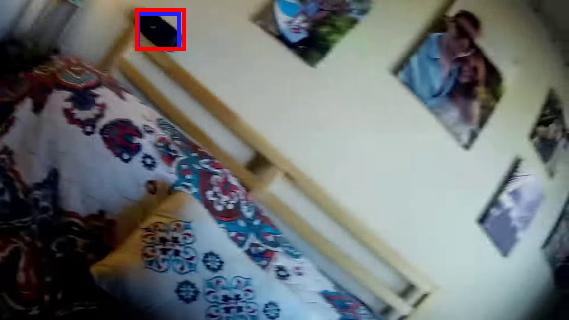

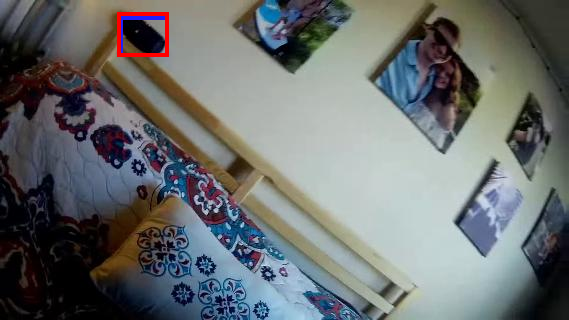

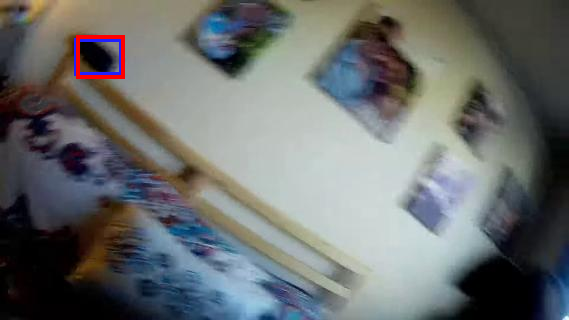

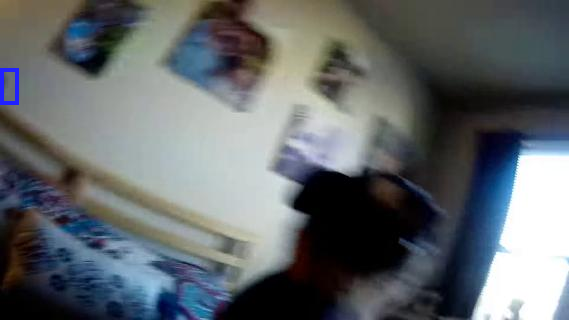

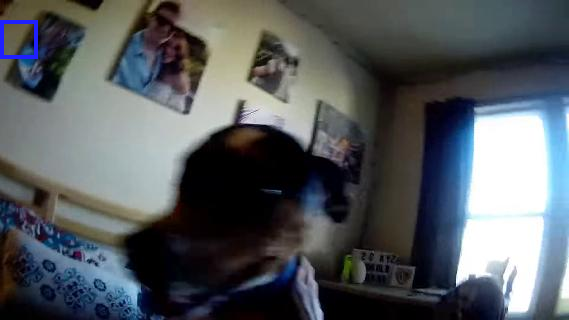

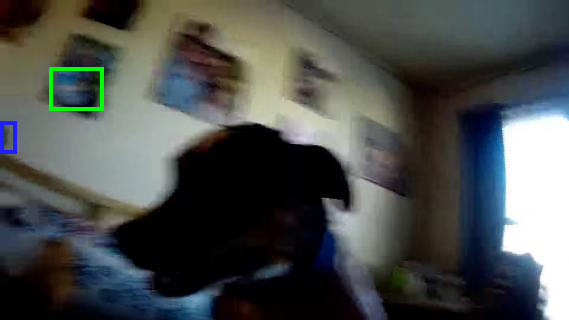

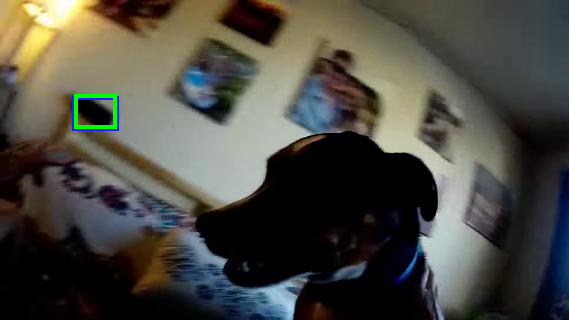

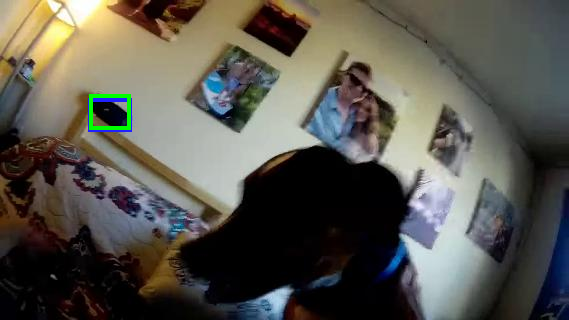

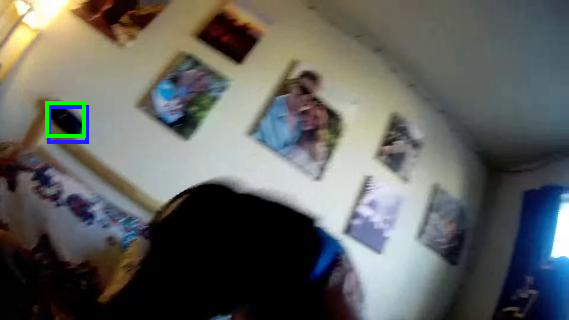

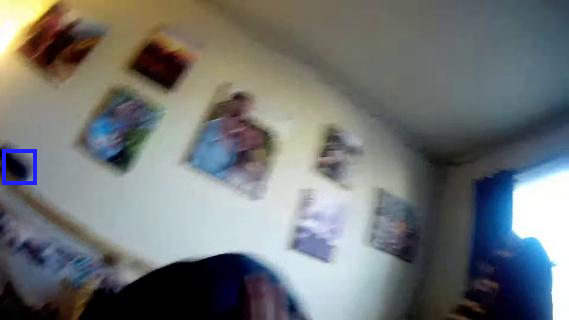

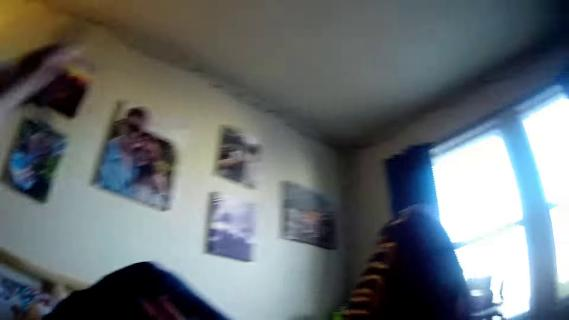

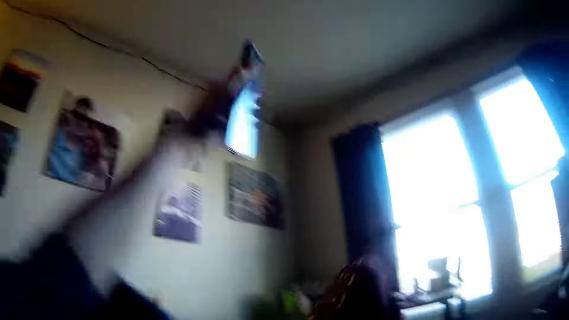

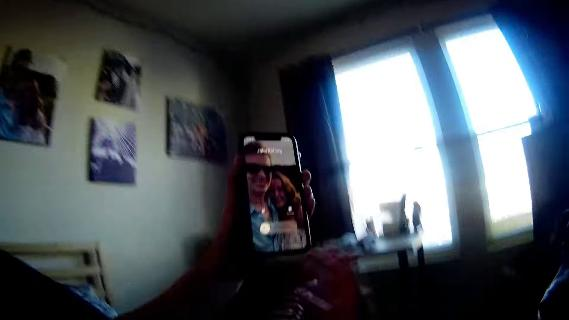

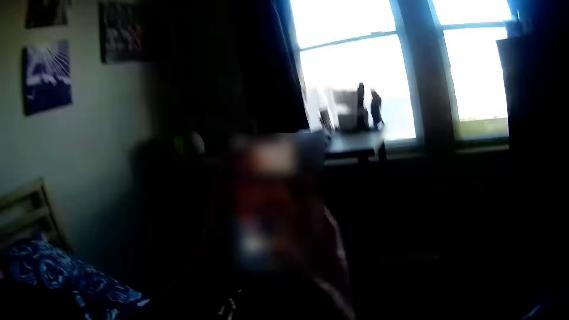

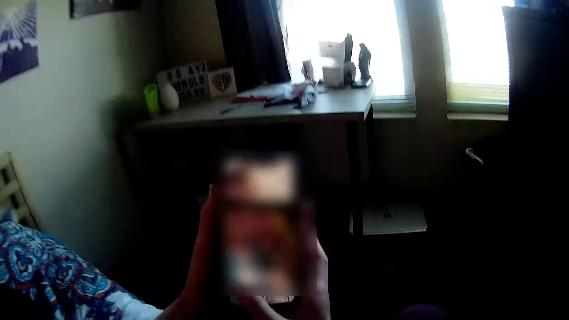

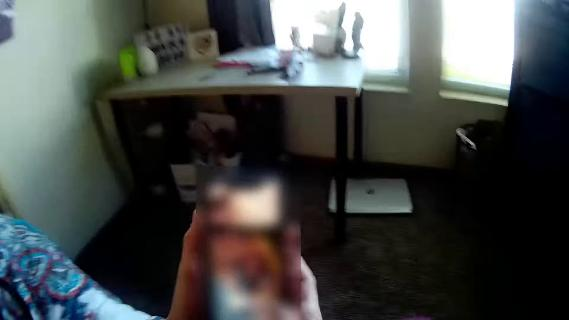

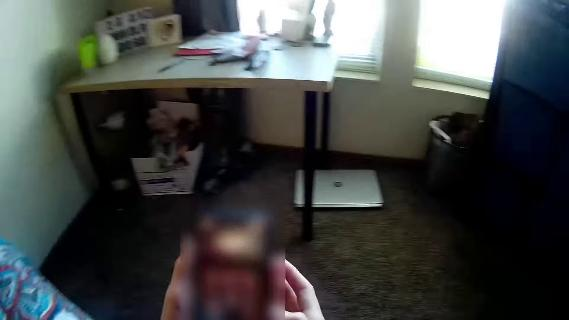

In [40]:
oh, ow = quid2ann[qset_uuid]['original_height'], quid2ann[qset_uuid]['original_width']
clip_uid = quid2ann[qset_uuid]['clip_uid']

fnos_gt = [bbox['fno'] for bbox in quid2ann[qset_uuid]['response_track']]
fnos1 = [bbox['fno'] for bbox in quid2pred1[qset_uuid]['bboxes']]
fnos2 = [bbox['fno'] for bbox in quid2pred2[qset_uuid]['bboxes']]
images = []
seg_idx_start = batch['seg_idxs'][0].min().item()
seg_idxs = list(range(seg_idx_start - 8, seg_idx_start + 48))
for fidx, seg_idx in enumerate(seg_idxs):
    image = Image.open(f'/local_datasets/ego4d_data/v2/vq2d_frames/320ss/{clip_uid}/frame_{seg_idx+1:07d}.jpg').convert('RGBA')
    w, h = image.size
    draw = ImageDraw.Draw(image)

    if seg_idx in fnos1:
        bbox = quid2pred1[qset_uuid]['bboxes'][fnos1.index(seg_idx)]
        px1, py1, px2, py2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
        px1, py1, px2, py2 = map(int, [px1 * w / ow, py1 * h / oh, px2 * w / ow, py2 * h / oh])
        draw.rectangle([(px1, py1), (px2, py2)], outline=(32, 32, 255), width=4)

    if seg_idx in fnos2:
        bbox = quid2pred2[qset_uuid]['bboxes'][fnos2.index(seg_idx)]
        ppx1, ppy1, ppx2, ppy2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
        ppx1, ppy1, ppx2, ppy2 = map(int, [ppx1 * w / ow, ppy1 * h / oh, ppx2 * w / ow, ppy2 * h / oh])
        draw.rectangle([(ppx1, ppy1), (ppx2, ppy2)], outline=(255, 0, 0), width=4)

    if seg_idx in fnos_gt:
        bbox = quid2ann[qset_uuid]['response_track'][fnos_gt.index(seg_idx)]
        gx1, gy1, gx2, gy2 = bbox['x'], bbox['y'], bbox['x'] + bbox['w'], bbox['y'] + bbox['h']
        gx1, gy1, gx2, gy2 = map(int, [gx1 * w / ow, gy1 * h / oh, gx2 * w / ow, gy2 * h / oh])
        draw.rectangle([(gx1, gy1), (gx2, gy2)], outline=(0, 255, 0), width=4)

    if fidx < 32:
        display(image)
    images.append(image)

In [41]:
import cv2
import numpy as np


# Parameters for the video
frame_rate = 5  # frames per second
output_path = f'outputs/viz/{qset_uuid}.mp4'
frame_size = images[0].size  # (width, height)

# OpenCV uses BGR color format, so PIL images need to be converted
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, frame_size)

for pil_img in images:
    frame = np.array(pil_img)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video_writer.write(frame)

# Release the video writer
video_writer.release()

print(f"Video saved to {output_path}")


Video saved to outputs/viz/2b21caa8-42e3-46ed-a7b6-7e47c0b03c98_2.mp4
